In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from math import ceil

2024-10-25 20:48:06.051217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 20:48:06.051318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 20:48:06.189202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Ensure GPU memory growth is enabled
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        for j in os.listdir(img_dir):
            img = os.path.join(img_dir, j)
            dd["images"] += [img]
            dd["labels"] += [i]
    return pd.DataFrame(dd)

In [6]:
# Load dataframes
train_df = create_df("/kaggle/input/yoga-classification-research-data/Yoga-16-July-30-2024/train")
val_df = create_df("/kaggle/input/yoga-classification-research-data/Yoga-16-July-30-2024/valid")
test_df = create_df("/kaggle/input/yoga-classification-research-data/Yoga-16-July-30-2024/test")

In [7]:
IMG_SIZE = 224
batch_size = 32
# Data Augmentation
"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure the test generator does not shuffle the data

Found 896 validated image filenames belonging to 16 classes.
Found 128 validated image filenames belonging to 16 classes.
Found 256 validated image filenames belonging to 16 classes.


In [9]:
# Define the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

83683744/83683744 [==============================] - 3s 0us/step


In [10]:
# Encode labels
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])
val_df['labels'] = le.transform(val_df['labels'])
test_df['labels'] = le.transform(test_df['labels'])

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [14]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)


In [15]:
# Adjust the steps_per_epoch and validation_steps to handle dataset size
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/100


I0000 00:00:1729889310.601620     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 7/28 [======>.......................] - ETA: 4s - loss: 2.7653 - accuracy: 0.0982

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 [==============================] - ETA: 0s - loss: 2.5077 - accuracy: 0.2388
Epoch 1: val_loss improved from inf to 2.17996, saving model to best_model.keras
28/28 [==============================] - 18s 404ms/step - loss: 2.5077 - accuracy: 0.2388 - val_loss: 2.1800 - val_accuracy: 0.4297 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 1.7548 - accuracy: 0.6875
Epoch 2: val_loss improved from 2.17996 to 1.69267, saving model to best_model.keras
28/28 [==============================] - 7s 253ms/step - loss: 1.7548 - accuracy: 0.6875 - val_loss: 1.6927 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 1.2672 - accuracy: 0.7913
Epoch 3: val_loss improved from 1.69267 to 1.36797, saving model to best_model.keras
28/28 [==============================] - 7s 262ms/step - loss: 1.2672 - accuracy: 0.7913 - val_loss: 1.3680 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 4/100
28/28 [============

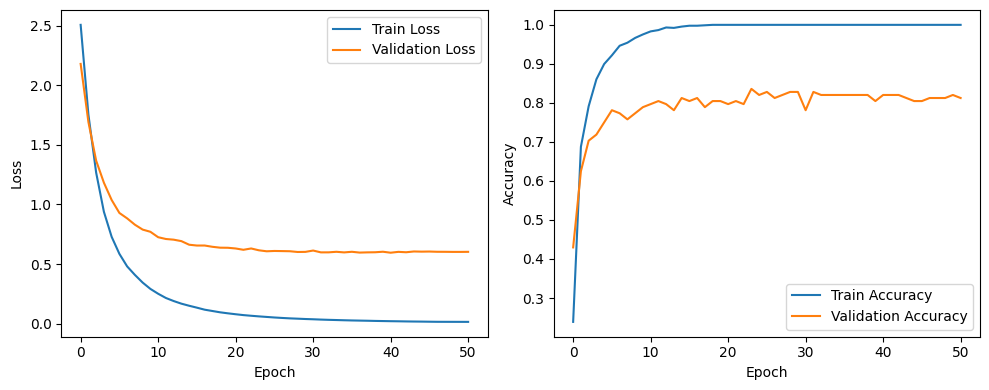

In [16]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
# After training the model
plot_training_history(history)

In [17]:
# Load the best model
model.load_weights('best_model.keras')

In [18]:
# Predict on the test set
test_generator.reset()
preds = model.predict(test_generator, steps=ceil(test_generator.samples / batch_size), verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes

8/8 [==============================] - 3s 311ms/step


In [19]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming true_labels and pred_labels are defined
class_names = [
    "Chair Pose",
    "Dolphin Plank Pose",
    "Downward Facing Dog Pose",
    "Fish Pose",
    "Goddess Pose",
    "Locust Pose",
    "Lord of the Dance Pose",
    "Low Lunge Pose",
    "Seated Forward Bend Pose",
    "Side Plank Pose",
    "Staff Pose",
    "Tree Pose",
    "Warrior 1 Pose",
    "Warrior 2 Pose",
    "Warrior 3 Pose",
    "Wide Angle Seated Forward Bend Pose"
]

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# Convert metrics to percentages
acc = accuracy_score(true_labels, pred_labels)
overall_accuracy = acc * 100

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, pred_labels, average='weighted') * 100
overall_recall = recall_score(true_labels, pred_labels, average='weighted') * 100
overall_f1 = f1_score(true_labels, pred_labels, average='weighted') * 100

# Prepare data for DataFrame
data = {
    "Class": [],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1-score (%)": []
}

# Populate data for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        per_class_accuracy = metrics['recall'] * 100  # Recall is equivalent to per-class accuracy
        data["Class"].append(class_name)
        data["Accuracy (%)"].append(f"{per_class_accuracy:.2f}")
        data["Precision (%)"].append(f"{metrics['precision'] * 100:.2f}")
        data["Recall (%)"].append(f"{metrics['recall'] * 100:.2f}")
        data["F1-score (%)"].append(f"{metrics['f1-score'] * 100:.2f}")

# Create a DataFrame
df_report = pd.DataFrame(data)

# Print overall accuracy and additional metrics
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1 Score: {overall_f1:.2f}%\n")

# Print the DataFrame
print(df_report.to_string(index=False))

Overall Accuracy: 84.38%
Overall Precision: 84.21%
Overall Recall: 84.38%
Overall F1 Score: 84.21%

                              Class Accuracy (%) Precision (%) Recall (%) F1-score (%)
                         Chair Pose        87.50         87.50      87.50        87.50
                 Dolphin Plank Pose       100.00        100.00     100.00       100.00
           Downward Facing Dog Pose        93.75         88.24      93.75        90.91
                          Fish Pose        68.75         78.57      68.75        73.33
                       Goddess Pose        93.75         88.24      93.75        90.91
                        Locust Pose        81.25         81.25      81.25        81.25
             Lord of the Dance Pose        87.50         87.50      87.50        87.50
                     Low Lunge Pose        68.75         73.33      68.75        70.97
           Seated Forward Bend Pose        87.50         87.50      87.50        87.50
                    Side Plank

[[14  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 11  0  2  0  0  1  0  0  0  0  0  0  2]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  2  0 13  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0 14  0  0  0  0  0  0  0  1  0]
 [ 1  0  1  0  1  0  0 11  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  0  0 14  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0 12  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 14  0  1  1  0]
 [ 1  0  0  0  0  1  0  1  0  2  1  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  1  1 13  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  1  0  0  0  1  1  0  0  0  0  0  0 13]]


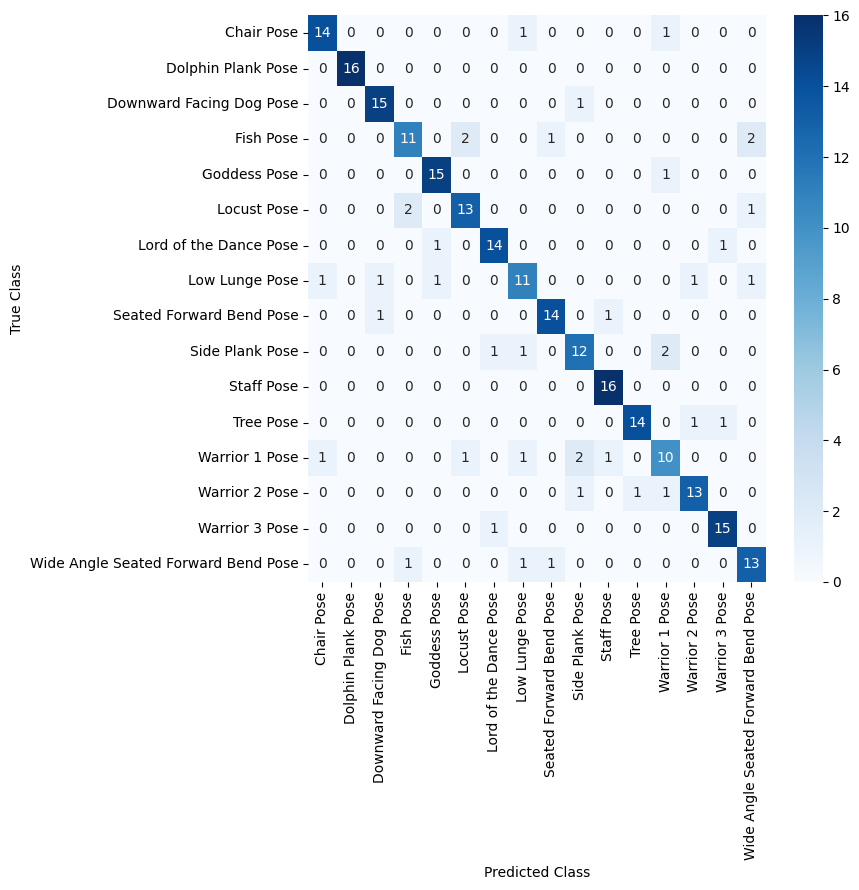

In [20]:
# Plot confusion matrix with class names
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(conf_matrix)
plt.figure(figsize=(9, 9))

# Use class_names for x-ticks and y-ticks
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)  # Rotate x-tick labels for better readability
plt.yticks(rotation=0)   # Keep y-tick labels horizontal
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

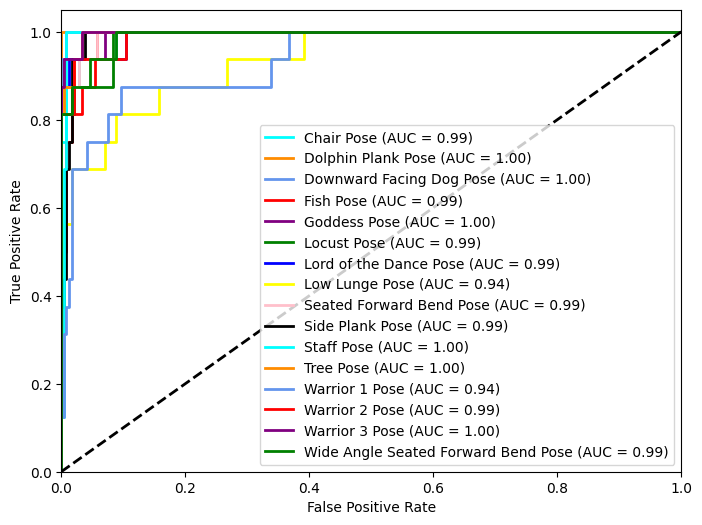

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Number of classes
n_classes = len(class_names)

# Binarize the true labels for multi-class ROC computation
y_test_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'yellow', 'pink', 'black'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show the plot
plt.show()